In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import cv2
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import display, HTML
import json
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
import json

tf.keras.mixed_precision.set_global_policy("mixed_float16") # use mixed-precision to reduce computation time

## Auxiliary functions

In [ ]:
def print_img(data, n_rows=2, n_columns=5, num_img=10, labels = None, start=0, end=None):

    '''
    The print_img function is designed to display a sample of images from a given dataset.
    It provides a visual representation of the images in a grid format, allowing users to
    inspect a specified number of images with optional corresponding labels.

    Parameters
    ----------

    data: The input dataset containing images.

    n_rows: (optional) Number of rows in the display grid. Default is 2.

    n_columns: (optional) Number of columns in the display grid. Default is 5.

    num_img: (optional) Total number of images to display. Default is 10.

    labels: (optional) Labels corresponding to the displayed images. If provided, labels will be used as titles for the images. Default is None.

    start: (optional) Starting index of the images to display. Default is 0.

    end: (optional) Ending index of the images to display. If not provided, it defaults to start + num_img.
    '''

    # Display a sample of images from the training-validation dataset
    _, axes = plt.subplots(n_rows, n_columns, figsize=(20, 10))

    if end == None:
        end = start + num_img
    j = 0
    # Iterate through the selected number of images
    for i in range(start, end, 1):
        ax = axes[j // n_columns, j % n_columns]

        ax.imshow(data[i])
        ax.axis('off')
        if labels != None:
            ax.set_title('{}'.format(labels[i]))
        j +=1


    # Adjust layout and display the images
    plt.tight_layout()
    plt.show()

In [ ]:
def remove_outliers(data, labels, outlier_list=(58, 338)):
    '''
    The remove_outliers function is designed to filter out specified outliers from a dataset,
    considering both the data and corresponding labels. Outliers are identified based on their
    indices in the original dataset.

    Parameters
    ----------

    data: The input data array from which outliers will be removed.

    labels: The corresponding labels for the input data.

    outlier_list: (optional) A list containing indices of data points considered as outliers. Default is (58, 338).
    '''

    outliers = []

    for i in outlier_list:
        outliers.append(data[i])

    for i, _ in enumerate(outlier_list):
        mask = ~np.all(data == outliers[i], axis = (1,2, 3))
        data = data[mask]
        labels = labels[mask]

    return data, labels

In [ ]:
def remove_duplicates(X, y):

    '''
    The remove_duplicates function is designed to eliminate duplicate entries from a dataset, considering both
    the input data (X) and corresponding labels (y). The function retains only unique samples based on the
    values in the input data array.

    Parameters
    ----------

    X: The input data array containing samples.

    y: The corresponding labels for the input data.
    '''

    unique_indices = np.unique(X, return_index=True, axis=0)[1]

    X = X[unique_indices]
    y = y[unique_indices]

    return np.array(X), np.array(y)

In [ ]:
def plot_history(history):
  best_epoch = np.argmax(history['val_accuracy'])

  # Plot the re-trained and the transfer learning efficientNetV2 training histories
  plt.figure(figsize=(20,5))
  plt.plot(history['accuracy'], color='#FF0000', label='Training Accuracy')
  plt.plot(history['val_accuracy'], color='#4D61E2', label='Validation Accuracy')
  plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
  plt.legend(loc='upper left')
  plt.title('Accuracy')
  plt.grid(alpha=.3)

  plt.figure(figsize=(20,5))
  plt.plot(history['loss'], color='#FF0000', label='Training Loss')
  plt.plot(history['val_loss'], color='#4D61E2', label='Validation Loss')
  plt.plot(best_epoch, history['val_loss'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
  plt.legend(loc='upper right')
  plt.title('Crossentropy')
  plt.grid(alpha=.3)

  plt.show()

In [ ]:
def plot_confusion_matrix(predictions, y_test, labels=()):

    '''
    This function is designed to visualize and evaluate the performance of a binary classification model by displaying a
    confusion matrix and computing various classification metrics such as accuracy, precision, recall, and F1 score.
    predictions

    Parameters
    ----------
    predictions: The model's predictions on the test data.

    y_test: The true labels for the test data.

    labels: List of labels corresponding to the classes in the classification problem.
    '''

    # Display the shape of the predictions
    print("Predictions Shape:", predictions.shape)
    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

    # Compute classification metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

    # Display the computed metrics
    print('Accuracy:', accuracy.round(4))
    print('Precision:', precision.round(4))
    print('Recall:', recall.round(4))
    print('F1:', f1.round(4))

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=list(labels), yticklabels=list(labels), cmap='Oranges')
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

    tp, fp, fn, tn = cm.ravel()
    print("True Positive {}".format(tp))
    print("False Positive {}".format(fp))
    print("False Negative {}".format(fn))
    print("True Negative {}".format(tn))


In [ ]:
def save_model(model, model_prefix=""):
    # Get a list of all files and directories in the current directory
    all_files = os.listdir()

    # Filter out directories that match the model prefix
    model_directories = [d for d in all_files if os.path.isdir(d) and d.startswith(model_prefix)]

    # If there are no existing models, start with version 1
    if not model_directories:
        new_version = 1
    else:
        # Extract version numbers from existing model directories
        existing_versions = [int(d[len(model_prefix):]) for d in model_directories]
        # Find the latest version
        latest_version = max(existing_versions)
        # Increment the latest version for the new model
        new_version = latest_version + 1

    # Construct the new model directory name
    new_model_name = f'{model_prefix}{new_version}'

    # Save the model
    model.save(new_model_name)

    # Delete the model from memory
    del model

    print(f'Saved model as {new_model_name}')

In [ ]:
def modify_filename_if_exists(directory, filename):
    # Check if the file exists in the directory
    if filename in os.listdir(directory):
        # Split the filename into name and extension
        name, extension = os.path.splitext(filename)
        # Modify the name
        new_name = f"{name}_bis{extension}"
        return new_name
    else:
        # Return the original name if it doesn't exist in the directory
        return filename

In [ ]:
def convert_history_to_serializable(history_dict):
    # Convert each value in the history to a native Python type
    return {key: [float(val) for val in values] for key, values in history_dict.items()}

## Data import

In [ ]:
# Extracting data from public_data.npz
file = np.load('public_data.npz', allow_pickle=True)

# Creating the two numpy arrays
data = file['data']
labels = file['labels']

## Inspect data

In [ ]:
# Inspecting data and labels shape
print("Data shape: {}".format(data.shape))
print("Labels shape: {}".format(labels.shape))

# Checking data range
print("\nMax data: {}".format(np.max(data)))
print("Min data: {}".format(np.min(data)))

# Check data types
print("\nData: {}".format(data[0][0][0][0]))
print("Data type: {}".format(type(data[0][0][0][0])))

# Display the count of occurrences of label classes in the dataset
print('Counting occurrences of label classes:')
print(pd.DataFrame(labels, columns=['class'])['class'].value_counts())

Data shape: (5200, 96, 96, 3)
Labels shape: (5200,)

Max data: 255.0
Min data: 0.0

Data: 20.0
Data type: <class 'numpy.float32'>
Counting occurrences of label classes:
healthy      3199
unhealthy    2001
Name: class, dtype: int64


In [ ]:
# Change to int to plot
data = data.astype(np.uint8)

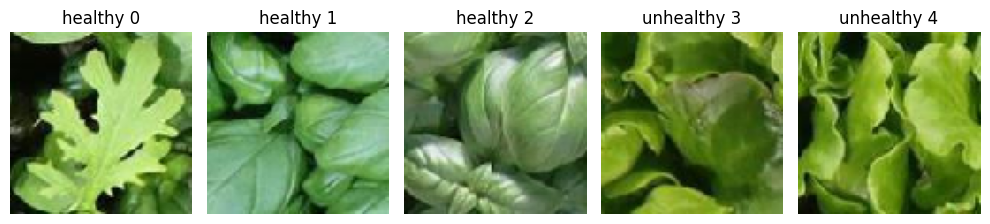

In [ ]:
# Plot images
print_img(data=data, n_rows=1, n_columns=5, num_img=5, labels=labels)

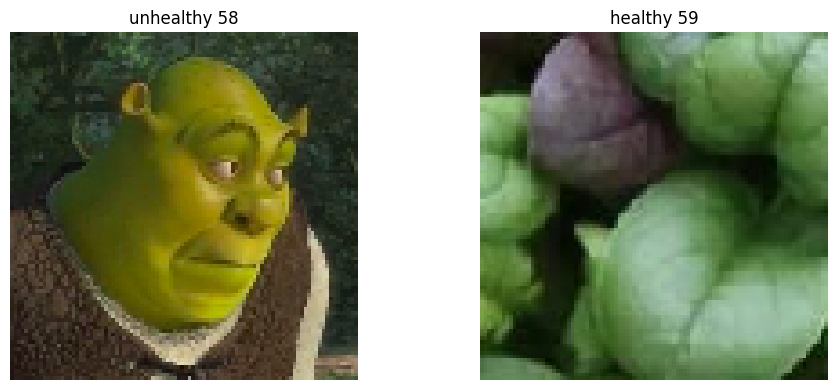

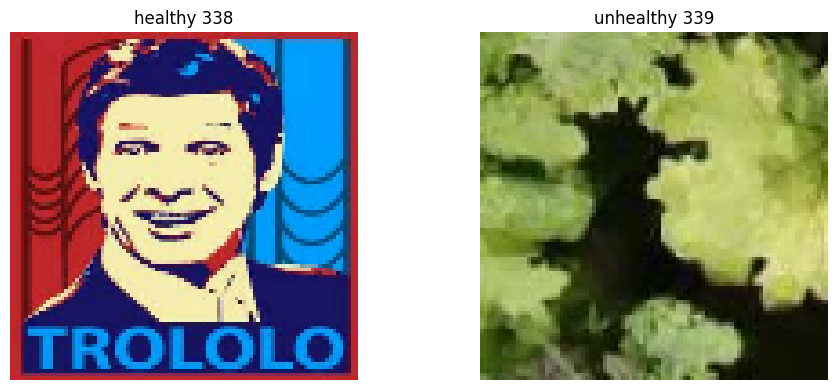

In [ ]:
# Plot outliers
print_img(data=data, n_rows=1, n_columns=2, num_img=2, labels=labels, start=58)

print_img(data=data, n_rows=1, n_columns=2, num_img=2, labels=labels, start=338)

Found duplicated images at indices 1 and 523


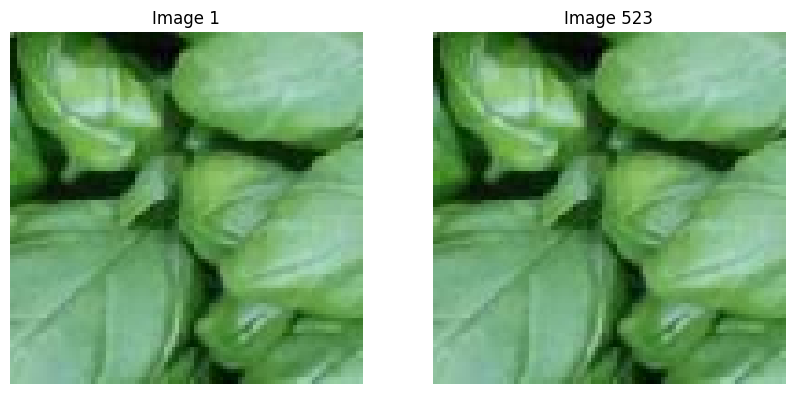

In [ ]:
def find_and_plot_duplicates(data):
    num_images = data.shape[0]

    # Iterate through each pair of images
    for i in range(num_images):
        for j in range(i + 1, num_images):
            # Check if the images are identical
            if np.array_equal(data[i], data[j]):
                print(f"Found duplicated images at indices {i} and {j}")

                # Plot the duplicated images
                fig, axes = plt.subplots(1, 2, figsize=(10, 5))

                axes[0].imshow(data[i])
                axes[0].axis('off')
                axes[0].set_title(f'Image {i}')

                axes[1].imshow(data[j])
                axes[1].axis('off')
                axes[1].set_title(f'Image {j}')

                plt.show()
                return  # Stop after the first pair is found

    print("No duplicated images found.")


# Assuming 'data' is your four-dimensional numpy array of RGB images
find_and_plot_duplicates(data)


## Dataset cleaning

In [ ]:
data,labels = remove_outliers(data, labels)

In [ ]:
print("data shape: {}".format(np.shape(data)))
print("labels shape: {}".format(np.shape(labels)))

data shape: (5004, 96, 96, 3)
labels shape: (5004,)


In [ ]:
# Bring labels to categoricals and 1-hot encoding
y = np.where(labels == 'healthy', 0, 1)
y = tfk.utils.to_categorical(y, num_classes=len(np.unique(y)))

In [ ]:
print("data shape: {}".format(np.shape(data)))
print("labels shape: {}".format(np.shape(y)))

data shape: (5004, 96, 96, 3)
labels shape: (5004, 2)


In [ ]:
data, y = remove_duplicates(data, y)

print(pd.DataFrame(labels, columns=['class'])['class'].value_counts())

healthy      3101
unhealthy    1903
Name: class, dtype: int64


In [ ]:
print("data shape: {}".format(np.shape(data)))
print("labels shape: {}".format(np.shape(y)))

data shape: (4850, 96, 96, 3)
labels shape: (4850, 2)


In [ ]:
# Split train_validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    data,
    y,
    random_state=seed,
    test_size=.1,
    stratify=y)

# Split train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = len(X_test), # Ensure validation set size matches test set size
    random_state=seed,
    stratify=y_train_val
)

y_train_num = [row[0] for row in y_train]  # Extract info from first cell of each element

# Create DataFrame and count values
count_num_cl = pd.Series(y_train_num).value_counts()

print("Number of positives and negatives: ")
print(count_num_cl)

Number of positives and negatives: 
1.0    2448
0.0    1432
dtype: int64


In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
X_val = np.array(X_val)
y_val = np.array(y_val)

In [ ]:
X_test = np.array(X_test)
y_test = np.array(y_test)

## Building a baseline model

In [ ]:
def build_model(input_shape, img_size = 260, seed=seed):

    '''
    The build_model function is designed to construct and compile a deep learning model for binary image classification.
    The architecture is based on the EfficientNetV2B2 model with additional layers for feature extraction and classification.
    The function also includes data augmentation techniques to enhance the model's robustness.

    Parameters
    ----------

    input_shape: The shape of the input data (excluding batch size). It represents the dimensions of the input image.

    dropout_rate: (optional) The dropout rate applied to prevent overfitting. Default value is 0.1.

    seed: (optional) Seed value for reproducibility.

    img_size: (optional) The target size to which input images are resized during data augmentation. Default value is 224.

    '''

    # Create an input layer with shape (input_shape)
    inputs = tfk.Input(shape = input_shape)

    # Resize inputs to match network input size
    x = tfkl.Resizing(img_size, img_size) (inputs)
    x = tfkl.Reshape((img_size,img_size,3)) (x)

    # Implementing EfficientNetV2B2 from keras.applications
    efficientNet = tfk.applications.EfficientNetV2B2(
        input_shape = (img_size, img_size, 3),
        include_top = False,
        weights = "imagenet",
        pooling = 'avg'
    )
    tfk.utils.plot_model(efficientNet, show_shapes=True)

    # Use the supernet as feature extractor, i.e. freeze all its weigths
    efficientNet.trainable = False

    # Connect efficientNetV2 to the input
    model_output = efficientNet(x)

    hidden_layer = tfkl.Dense(units = 16, kernel_initializer = tfk.initializers.HeUniform(seed = seed), name = 'HiddenDense1')(model_output)
    hidden_activation = tfkl.Activation('relu', name = 'HiddenActivation1')(hidden_layer)

    # Add a Dense layer with 2 units and softmax activation as the classifier
    outputs_layer = tfkl.Dense(2, activation = 'softmax')(hidden_activation)
    # Create a Model connecting input and output
    model = tfk.Model(inputs = inputs, outputs = outputs_layer, name = 'model')

    # Compile the model with Binary Cross-Entropy loss and Adam optimizer.
    # Monitoring the accuracy of the model
    model.compile(loss = tfk.losses.BinaryCrossentropy(), optimizer = tfk.optimizers.Adam(), metrics = ['accuracy'])

    return model

In [ ]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 1024
epochs = 200

# Print input and output shapes
print(f"Input Shape: {input_shape}\nOutput Shape: {output_shape}")

Input Shape: (96, 96, 3)
Output Shape: (2,)


In [ ]:
model = build_model(input_shape=input_shape,
                    seed=seed)

model.summary()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.84678 to fit

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resizing_1 (Resizing)       (None, 260, 260, 3)       0         
                                                                 
 reshape_1 (Reshape)         (None, 260, 260, 3)       0         
                                                                 
 efficientnetv2-b2 (Functio  (None, 1408)              8769374   
 nal)                                                            
                                                                 
 HiddenDense1 (Dense)        (None, 16)                22544     
                                                                 
 HiddenActivation1 (Activat  (None, 16)         

In [ ]:
# Dictionary to be used to show all the networks performances in a single graph
all_histories = {}

In [ ]:
history_bl = model.fit(
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val), y_val)
).history

all_histories['baseline'] = history_bl

Epoch 1/200
4/4 [==============================] - 86s 14s/step - loss: 0.6813 - accuracy: 0.5832 - val_loss: 0.6567 - val_accuracy: 0.6309
Epoch 2/200
4/4 [==============================] - 6s 1s/step - loss: 0.6432 - accuracy: 0.6307 - val_loss: 0.6333 - val_accuracy: 0.6309
Epoch 3/200
4/4 [==============================] - 6s 2s/step - loss: 0.6192 - accuracy: 0.6454 - val_loss: 0.6108 - val_accuracy: 0.6392
Epoch 4/200
4/4 [==============================] - 6s 2s/step - loss: 0.5926 - accuracy: 0.6753 - val_loss: 0.5933 - val_accuracy: 0.6515
Epoch 5/200
4/4 [==============================] - 6s 1s/step - loss: 0.5732 - accuracy: 0.6915 - val_loss: 0.5776 - val_accuracy: 0.6845
Epoch 6/200
4/4 [==============================] - 6s 1s/step - loss: 0.5544 - accuracy: 0.7193 - val_loss: 0.5635 - val_accuracy: 0.7093
Epoch 7/200
4/4 [==============================] - 7s 2s/step - loss: 0.5390 - accuracy: 0.7343 - val_loss: 0.5479 - val_accuracy: 0.7402
Epoch 8/200
4/4 [===============

In [ ]:
# save history as json
name = 'baseline.json'

# Directory containing history JSON files
history_dir = './Histories_salvate'

if not os.path.exists(history_dir):
  print("Not working")

serializable_history = convert_history_to_serializable(history_bl)

# To avoid deleting past histories if the name does not get changed
name = modify_filename_if_exists(directory=history_dir, filename=name)

file_path = os.path.join(history_dir, name)

with open(file_path, 'w') as f:
    json.dump(serializable_history, f)

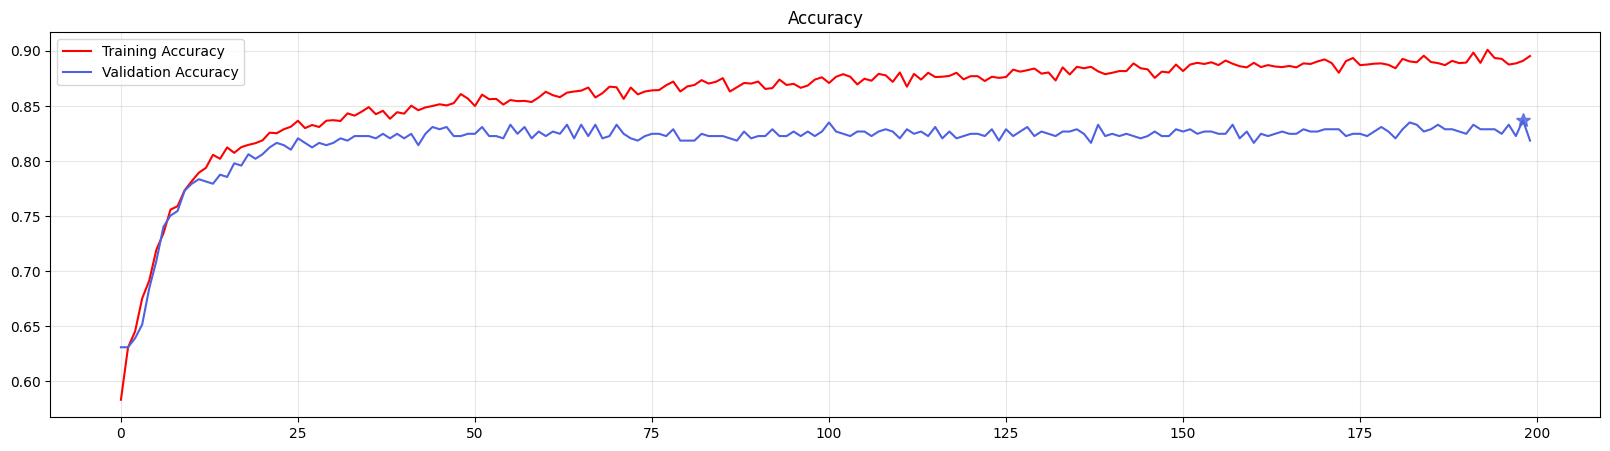

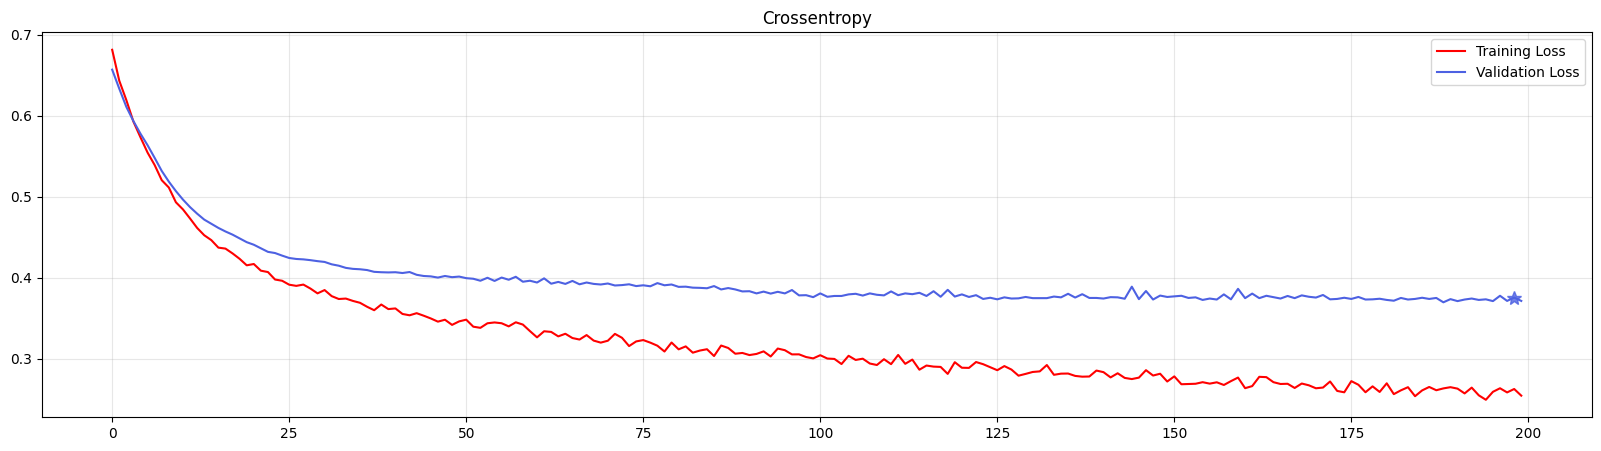

In [ ]:
plot_history(history_bl)

In [ ]:
best_epoch = np.argmax(history_bl['val_accuracy'])

print("Best epoch {}".format(best_epoch))
validation_accuracy = model.evaluate(preprocess_input(X_val),y_val,verbose=0)[-1]
print('Validation set accuracy %.4f' % validation_accuracy)
test_accuracy = model.evaluate(preprocess_input(X_test),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Best epoch 198
Validation set accuracy 0.8186
Test set accuracy 0.8619


Predictions Shape: (485, 2)
Accuracy: 0.8619
Precision: 0.856
Recall: 0.8442
F1: 0.8493


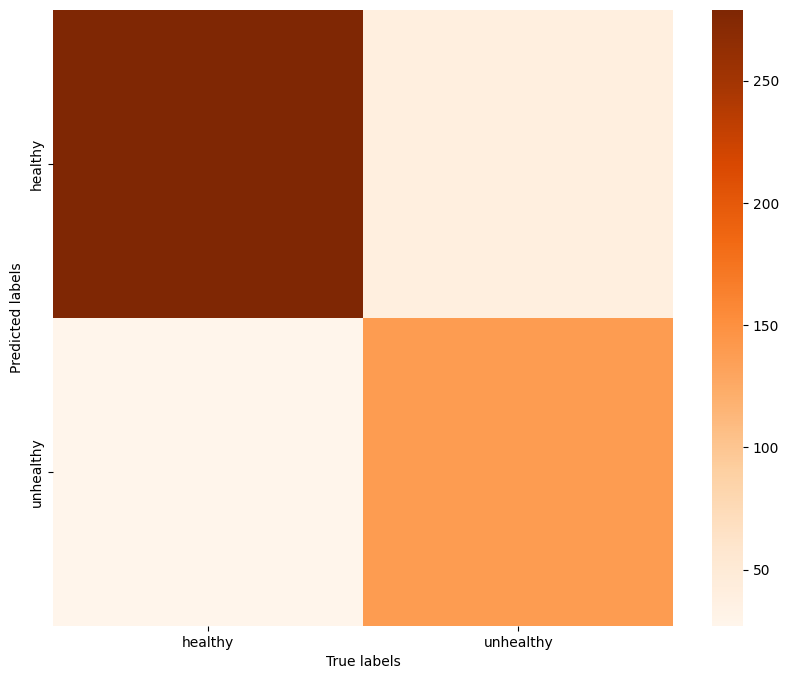

True Positive 279
False Positive 27
False Negative 40
True Negative 139


In [ ]:
plot_confusion_matrix(model=model, X_test=X_test, y_test=y_test, labels=labels)

## Early stopping

In [ ]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor = 'val_accuracy',       # Metric to monitor
    patience = 25,                  # Number of epochs with no improvement after which traing will be stopped
    restore_best_weights = True,    # Restore value of weights at best epoch
    mode = 'auto'                   # Mode to decide when to stop training
    )

In [ ]:
callbacks = [early_stopping]

In [ ]:
model = build_model(input_shape=input_shape,
                    seed=seed)

model.summary()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.84678 to fit

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resizing_2 (Resizing)       (None, 260, 260, 3)       0         
                                                                 
 reshape_2 (Reshape)         (None, 260, 260, 3)       0         
                                                                 
 efficientnetv2-b2 (Functio  (None, 1408)              8769374   
 nal)                                                            
                                                                 
 HiddenDense1 (Dense)        (None, 16)                22544     
                                                                 
 HiddenActivation1 (Activat  (None, 16)         

In [ ]:
history = model.fit(
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val), y_val),
    callbacks = callbacks
).history

all_histories['early_stopping'] = history_bl

In [ ]:
# save history as json
name = 'early_stopping.json'

# Directory containing history JSON files
history_dir = './Histories_salvate'

if not os.path.exists(history_dir):
  print("Not working")

serializable_history = convert_history_to_serializable(history_bl)

# To avoid deleting past histories if the name does not get changed
name = modify_filename_if_exists(directory=history_dir, filename=name)

file_path = os.path.join(history_dir, name)

with open(file_path, 'w') as f:
    json.dump(serializable_history, f)

In [ ]:
best_epoch = np.argmax(history_bl['val_accuracy'])

print("Best epoch {}".format(best_epoch))
validation_accuracy = model.evaluate(preprocess_input(X_val),y_val,verbose=0)[-1]
print('Validation set accuracy %.4f' % validation_accuracy)
test_accuracy = model.evaluate(preprocess_input(X_test),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

In [ ]:
plot_confusion_matrix(model=model, X_test=X_test, y_test=y_test, labels=labels)

## Learning Rate Scheduling

In [ ]:
lr_patience = 5

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor = 'val_accuracy', # Metric to monitor
    patience = lr_patience,   # Number of epochs with no improvement after which learning rate will be reduced
    factor = 0.9,             # Factor by which the learning rate will be reduced
    mode = 'auto',            # Mode to decide when to reduce learning rate
    min_lr = 1e-5             # Minimum learning rate
)

In [ ]:
callbacks = [lr_scheduler]

In [ ]:
model = build_model(input_shape=input_shape,
                    seed=seed)

model.summary()

In [ ]:
history = model.fit(
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val), y_val),
    callbacks = callbacks
).history

all_histories['lr_scheduling'] = history

In [ ]:
# save history as json
name = 'lr_scheduling.json'

# Directory containing history JSON files
history_dir = './Histories_salvate'

if not os.path.exists(history_dir):
  print("Not working")

serializable_history = convert_history_to_serializable(history_bl)

# To avoid deleting past histories if the name does not get changed
name = modify_filename_if_exists(directory=history_dir, filename=name)

file_path = os.path.join(history_dir, name)

with open(file_path, 'w') as f:
    json.dump(serializable_history, f)

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])

print("Best epoch {}".format(best_epoch))
validation_accuracy = model.evaluate(preprocess_input(X_val),y_val,verbose=0)[-1]
print('Validation set accuracy %.4f' % validation_accuracy)
test_accuracy = model.evaluate(preprocess_input(X_test),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

In [ ]:
plot_confusion_matrix(model=model, X_test=X_test, y_test=y_test, labels=labels)

## Dropout

In [ ]:
def build_model(input_shape, dropout_rate, seed=seed):

    '''
    The build_model function is designed to construct and compile a deep learning model for binary image classification.
    The architecture is based on the EfficientNetV2B2 model with additional layers for feature extraction and classification.
    The function also includes data augmentation techniques to enhance the model's robustness.

    Parameters
    ----------

    input_shape: The shape of the input data (excluding batch size). It represents the dimensions of the input image.

    dropout_rate: (optional) The dropout rate applied to prevent overfitting. Default value is 0.1.

    seed: (optional) Seed value for reproducibility.

    img_size: (optional) The target size to which input images are resized during data augmentation. Default value is 224.
    '''

    # Create an input layer with shape (input_shape)
    inputs = tfk.Input(shape = input_shape)

    # Implementing EfficientNetV2B2 from keras.applications
    efficientNet = tfk.applications.EfficientNetV2B2(
        input_shape = input_shape,
        include_top = False,
        weights = "imagenet",
        pooling = 'avg'
    )
    tfk.utils.plot_model(efficientNet, show_shapes=True)

    # Use the supernet as feature extractor, i.e. freeze all its weigths
    efficientNet.trainable = False

    # Connect efficientNetV2 to the input
    model_output = efficientNet(inputs)

    hidden_layer = tfkl.Dense(units = 16, kernel_initializer = tfk.initializers.HeUniform(seed = seed), name = 'HiddenDense1')(model_output)
    hidden_activation = tfkl.Activation('relu', name = 'HiddenActivation1')(hidden_layer)

    dropout_layer = tfkl.Dropout(dropout_rate, seed=seed)(hidden_activation)

    # Add a Dense layer with 2 units and softmax activation as the classifier
    outputs_layer = tfkl.Dense(2, activation = 'softmax')(dropout_layer)
    # Create a Model connecting input and output
    model = tfk.Model(inputs = inputs, outputs = outputs_layer, name = 'model')

    # Compile the model with Binary Cross-Entropy loss and Adam optimizer.
    # Monitoring the accuracy of the model
    model.compile(loss = tfk.losses.BinaryCrossentropy(), optimizer = tfk.optimizers.Adam(), metrics = ['accuracy'])

    return model

In [ ]:
dropout_rate = 0.2
model = build_model(input_shape=input_shape, dropout_rate=dropout_rate, seed=seed)

model.summary()

In [ ]:
history = model.fit(
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val), y_val)
    callbacks = callbacks
).history

all_histories['dropout'] = history

In [ ]:
# save history as json
name = 'dropout.json'

# Directory containing history JSON files
history_dir = './Histories_salvate'

if not os.path.exists(history_dir):
  print("Not working")

serializable_history = convert_history_to_serializable(history_bl)

# To avoid deleting past histories if the name does not get changed
name = modify_filename_if_exists(directory=history_dir, filename=name)

file_path = os.path.join(history_dir, name)

with open(file_path, 'w') as f:
    json.dump(serializable_history, f)

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])

print("Best epoch {}".format(best_epoch))
validation_accuracy = model.evaluate(preprocess_input(X_val),y_val,verbose=0)[-1]
print('Validation set accuracy %.4f' % validation_accuracy)
test_accuracy = model.evaluate(preprocess_input(X_test),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

In [ ]:
plot_confusion_matrix(model=model, X_test=X_test, y_test=y_test, labels=labels)

## KerasCV CutMix

In [ ]:
#! pip install keras_cv
import keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 40.8 MB/s eta 0:00:00
Using TensorFlow backend


In [ ]:
def CutMix(data, labels):
    augmenter = keras_cv.layers.CutMix()
    inputs = {"images": data, "labels": labels}
    outputs = augmenter(inputs)
    return outputs['images'].numpy(), outputs['labels'].numpy()

X_cut, y_cut = CutMix(X_train, y_train)

X_train = np.concatenate((X_train, X_cut), axis=0)
y_train = np.concatenate((y_train, y_cut), axis=0)

In [ ]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 1024
epochs = 200

In [ ]:
model = build_model(input_shape=input_shape,
                    seed=seed)

model.summary()

35839040/35839040 [==============================] - 0s 0us/step
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.84678 to fit

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 260, 260, 3)       0         
                                                                 
 reshape (Reshape)           (None, 260, 260, 3)       0         
                                                                 
 efficientnetv2-b2 (Functio  (None, 1408)              8769374   
 nal)                                                            
                                                                 
 HiddenDense1 (Dense)        (None, 16)                22544     
                                                 

In [ ]:
history = model.fit(
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val), y_val),
).history

all_histories['cutmix'] = history

Epoch 1/200
8/8 [==============================] - 73s 5s/step - loss: 0.6678 - accuracy: 0.6076 - val_loss: 0.6328 - val_accuracy: 0.6330
Epoch 2/200
8/8 [==============================] - 10s 1s/step - loss: 0.6244 - accuracy: 0.6528 - val_loss: 0.5996 - val_accuracy: 0.6474
Epoch 3/200
8/8 [==============================] - 10s 1s/step - loss: 0.5925 - accuracy: 0.6807 - val_loss: 0.5610 - val_accuracy: 0.7258
Epoch 4/200
8/8 [==============================] - 11s 1s/step - loss: 0.5665 - accuracy: 0.7112 - val_loss: 0.5312 - val_accuracy: 0.7485
Epoch 5/200
8/8 [==============================] - 11s 1s/step - loss: 0.5454 - accuracy: 0.7323 - val_loss: 0.5098 - val_accuracy: 0.7773
Epoch 6/200
8/8 [==============================] - 10s 1s/step - loss: 0.5348 - accuracy: 0.7427 - val_loss: 0.4976 - val_accuracy: 0.7732
Epoch 7/200
8/8 [==============================] - 11s 1s/step - loss: 0.5242 - accuracy: 0.7530 - val_loss: 0.4834 - val_accuracy: 0.7918
Epoch 8/200
8/8 [==========

In [ ]:
# save history as json
name = 'cutmix.json'

# Directory containing history JSON files
history_dir = './Histories_salvate'

if not os.path.exists(history_dir):
  print("Not working")

serializable_history = convert_history_to_serializable(history_bl)

# To avoid deleting past histories if the name does not get changed
name = modify_filename_if_exists(directory=history_dir, filename=name)

file_path = os.path.join(history_dir, name)

with open(file_path, 'w') as f:
    json.dump(serializable_history, f)

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])

print("Best epoch {}".format(best_epoch))
validation_accuracy = model.evaluate(preprocess_input(X_val),y_val,verbose=0)[-1]
print('Validation set accuracy %.4f' % validation_accuracy)
test_accuracy = model.evaluate(preprocess_input(X_test),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

In [ ]:
plot_confusion_matrix(model=model, X_test=X_test, y_test=y_test, labels=labels)

## SMOTE

In [ ]:
def smote_img(data, labels):
    dataForSmote = data.reshape(data.shape[0], 96 * 96 * 3)
    smote = SMOTE(sampling_strategy = 1)

    x_smote, y_smote = smote.fit_resample(dataForSmote , labels)

    X_smote = x_smote.reshape(x_smote.shape[0], 96, 96, 3)

    y_smote = tfk.utils.to_categorical(y_smote, num_classes=len(np.unique(labels)))

    return X_smote, y_smote

In [ ]:
X_train, y_train = smote_img(X_train, y_train)

In [ ]:
model = build_model(input_shape=input_shape,
                    seed=seed)

model.summary()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.84678 to fit

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resizing_1 (Resizing)       (None, 260, 260, 3)       0         
                                                                 
 reshape_1 (Reshape)         (None, 260, 260, 3)       0         
                                                                 
 efficientnetv2-b2 (Functio  (None, 1408)              8769374   
 nal)                                                            
                                                                 
 HiddenDense1 (Dense)        (None, 16)                22544     
                                                                 
 HiddenActivation1 (Activat  (None, 16)         

In [ ]:
history = model.fit(
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val), y_val),
).history

all_histories['smote'] = history

Epoch 1/200
5/5 [==============================] - 38s 6s/step - loss: 0.6906 - accuracy: 0.5611 - val_loss: 0.6572 - val_accuracy: 0.6268
Epoch 2/200
5/5 [==============================] - 7s 1s/step - loss: 0.6317 - accuracy: 0.6663 - val_loss: 0.6279 - val_accuracy: 0.6371
Epoch 3/200
5/5 [==============================] - 7s 1s/step - loss: 0.5843 - accuracy: 0.6840 - val_loss: 0.6050 - val_accuracy: 0.6619
Epoch 4/200
5/5 [==============================] - 7s 1s/step - loss: 0.5447 - accuracy: 0.7132 - val_loss: 0.5811 - val_accuracy: 0.6763
Epoch 5/200
5/5 [==============================] - 7s 1s/step - loss: 0.5075 - accuracy: 0.7663 - val_loss: 0.5630 - val_accuracy: 0.7320
Epoch 6/200
5/5 [==============================] - 7s 1s/step - loss: 0.4829 - accuracy: 0.7859 - val_loss: 0.5444 - val_accuracy: 0.7608
Epoch 7/200
5/5 [==============================] - 7s 1s/step - loss: 0.4589 - accuracy: 0.8035 - val_loss: 0.5254 - val_accuracy: 0.7546
Epoch 8/200
5/5 [================

In [ ]:
# save history as json
name = 'smote.json'

# Directory containing history JSON files
history_dir = './Histories_salvate'

if not os.path.exists(history_dir):
  print("Not working")

serializable_history = convert_history_to_serializable(history_bl)

# To avoid deleting past histories if the name does not get changed
name = modify_filename_if_exists(directory=history_dir, filename=name)

file_path = os.path.join(history_dir, name)

with open(file_path, 'w') as f:
    json.dump(serializable_history, f)

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])

print("Best epoch {}".format(best_epoch))
validation_accuracy = model.evaluate(preprocess_input(X_val),y_val,verbose=0)[-1]
print('Validation set accuracy %.4f' % validation_accuracy)
test_accuracy = model.evaluate(preprocess_input(X_test),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

In [ ]:
plot_confusion_matrix(model=model, X_test=X_test, y_test=y_test, labels=labels)

# MixUp

In [ ]:
def MixUp(x_train, labels_train, alpha=0.2):

    '''
    The MixUp function implements the MixUp data augmentation technique, which combines pairs of samples
    and their corresponding labels in a training dataset. This technique involves creating linear interpolations
    between two randomly selected samples and their labels to generate new augmented samples.

    Parameters
    ----------

    x_train: The input data array for training.

    labels_train: The corresponding labels for the training data.

    alpha: (optional) The alpha parameter controlling the strength of the MixUp augmentation. It represents the concentration of the beta distribution used to sample the mixing coefficient. Default value is 0.2.
    '''

    lam = np.random.beta(alpha, alpha)

    batch_size = x_train.shape[0]

    indices = np.random.permutation(batch_size)

    x_mix = lam * x_train + (1 - lam) * x_train[indices, :]
    labels_mix = lam * labels_train + (1 - lam) * labels_train[indices, :]

    return x_mix, labels_mix

In [ ]:
# Creating the MixUp Augmented samples
X_mix, y_mix = MixUP(X_train, y_train)

X_train = np.concatenate((X_train, X_mix), axis = 0)
y_train = np.concatenate((y_train, y_mix), axis = 0)

# Removing the duplicates that might arise
X_train, y_train = remove_duplicates(X_train, y_train)

In [ ]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 1024
epochs = 200

In [ ]:
model = build_model(input_shape=input_shape,
                    seed=seed)

model.summary()

In [ ]:
history = model.fit(
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val), y_val),
).history

all_histories['mixup'] = history

In [ ]:
# save history as json
name = 'mixup.json'

# Directory containing history JSON files
history_dir = './Histories_salvate'

if not os.path.exists(history_dir):
  print("Not working")

serializable_history = convert_history_to_serializable(history_bl)

# To avoid deleting past histories if the name does not get changed
name = modify_filename_if_exists(directory=history_dir, filename=name)

file_path = os.path.join(history_dir, name)

with open(file_path, 'w') as f:
    json.dump(serializable_history, f)

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])

print("Best epoch {}".format(best_epoch))
validation_accuracy = model.evaluate(preprocess_input(X_val),y_val,verbose=0)[-1]
print('Validation set accuracy %.4f' % validation_accuracy)
test_accuracy = model.evaluate(preprocess_input(X_test),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

In [ ]:
plot_confusion_matrix(model=model, X_test=X_test, y_test=y_test, labels=labels)

# Test Time Augmentation

In [ ]:
def tta(model, X_test, y_test, batch_size=32):

    '''
    The tta function implements Test Time Augmentation (TTA) using a pre-trained Keras model. TTA involves making predictions
    on augmented versions of test samples and aggregating these predictions to enhance the performance of the model.

    Parameters
    ----------

    model: The pre-trained Keras model for which TTA will be applied.

    X_test: The test data for which predictions will be made using TTA.

    y_test: The corresponding true labels for the test data.

    batch_size: The batch size used during TTA.
    '''

    img_augmentation = tf.keras.Sequential([
        tfkl.RandomRotation(factor=0.15),
        #tfkl.RandomTranslation(height_factor=0.1, width_factor=0.1),
        #tfkl.RandomFlip()
    ], name="img_augmentation")

    # Create an ImageDataGenerator with the defined augmentations
    data_generator = ImageDataGenerator(
        preprocessing_function=img_augmentation,
    )

    tta_steps = 5
    predictions = []

    for i in range(tta_steps):
        print(i)
        preds = model.predict_generator(data_generator.flow(X_test, batch_size=batch_size, shuffle=False), steps = len(X_test)/batch_size)
        predictions.append(preds)

    pred = np.mean(predictions, axis=0)

    out = np.mean(np.equal(np.argmax(y_test, axis=-1), np.argmax(pred, axis=-1)))

    mean = []
    out = []

    for i in range(len(X_test)):
        for j in range(tta_steps):
            mean.append(predictions[j][i][0])
        np.array(mean)
        out.append(np.mean(mean))

        mean = []

    res = [[elem, 1 - elem] for elem in out]

    out = tf.argmax(res, axis=-1)  # Shape [BS]

    return out

In [ ]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 1024
epochs = 200

In [ ]:
model = build_model(input_shape=input_shape,
                    seed=seed)

model.summary()

In [ ]:
history = model.fit(
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val), y_val),
).history

all_histories['tta'] = history

In [ ]:
# save history as json
name = 'tta.json'

# Directory containing history JSON files
history_dir = './Histories_salvate'

if not os.path.exists(history_dir):
  print("Not working")

serializable_history = convert_history_to_serializable(history_bl)

# To avoid deleting past histories if the name does not get changed
name = modify_filename_if_exists(directory=history_dir, filename=name)

file_path = os.path.join(history_dir, name)

with open(file_path, 'w') as f:
    json.dump(serializable_history, f)

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])

print("Best epoch {}".format(best_epoch))
validation_accuracy = model.evaluate(preprocess_input(X_val),y_val,verbose=0)[-1]
print('Validation set accuracy %.4f' % validation_accuracy)
test_accuracy = model.evaluate(preprocess_input(X_test),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

In [ ]:
plot_confusion_matrix(model=model, X_test=X_test, y_test=y_test, labels=labels)

## Weight Regularization

In [ ]:
def build_model(input_shape, img_size = 260, seed=seed):

    '''
    The build_model function is designed to construct and compile a deep learning model for binary image classification.
    The architecture is based on the EfficientNetV2B2 model with additional layers for feature extraction and classification.
    The function also includes data augmentation techniques to enhance the model's robustness.

    Parameters
    ----------

    input_shape: The shape of the input data (excluding batch size). It represents the dimensions of the input image.

    dropout_rate: (optional) The dropout rate applied to prevent overfitting. Default value is 0.1.

    seed: (optional) Seed value for reproducibility.

    img_size: (optional) The target size to which input images are resized during data augmentation. Default value is 224.
    '''

    # Create an input layer with shape (input_shape)
    inputs = tfk.Input(shape = input_shape)

    x = tfkl.Resizing(img_size, img_size) (inputs)
    x = tfkl.Reshape((img_size,img_size,3)) (x)

    # Implementing EfficientNetV2S from keras.applications
    efficientNet = tfk.applications.EfficientNetV2B2( # CHANGE network !!!!!
        input_shape = (img_size, img_size, 3),
        include_top = False,
        weights = "imagenet",
        pooling = 'avg'
    )
    tfk.utils.plot_model(efficientNet, show_shapes=True)

    # Use the supernet as feature extractor, i.e. freeze all its weigths
    efficientNet.trainable = False

    # Connect efficientNetV2 to the input
    model_output = efficientNet(x)

    hidden_layer = tfkl.Dense(units = 16, kernel_initializer = tfk.initializers.HeUniform(seed = seed), name = 'HiddenDense1')(model_output)
    hidden_activation = tfkl.Activation('relu', name = 'HiddenActivation1')(hidden_layer)

    # Add a Dense layer with 2 units and softmax activation as the classifier
    outputs_layer = tfkl.Dense(2, activation = 'softmax')(hidden_activation)
    # Create a Model connecting input and output
    model = tfk.Model(inputs = inputs, outputs = outputs_layer, name = 'model')

    # Compile the model with Binary Cross-Entropy loss and Adam optimizer.
    # Monitoring the accuracy of the model
    model.compile(loss = tfk.losses.BinaryCrossentropy(), optimizer = tfk.optimizers.AdamW(), metrics = ['accuracy'])

    return model

In [ ]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 1024
epochs = 200

In [ ]:
model = build_model(input_shape=input_shape,
                    seed=seed)

model.summary()

35839040/35839040 [==============================] - 0s 0us/step
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.84678 to fit

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 260, 260, 3)       0         
                                                                 
 reshape (Reshape)           (None, 260, 260, 3)       0         
                                                                 
 efficientnetv2-b2 (Functio  (None, 1408)              8769374   
 nal)                                                            
                                                                 
 HiddenDense1 (Dense)        (None, 16)                22544     
                                                 

In [ ]:
history = model.fit(
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val), y_val),
).history

all_histories['weight_regularization'] = history

Epoch 1/200
4/4 [==============================] - 73s 11s/step - loss: 0.6737 - accuracy: 0.5985 - val_loss: 0.6606 - val_accuracy: 0.6309
Epoch 2/200
4/4 [==============================] - 6s 1s/step - loss: 0.6408 - accuracy: 0.6330 - val_loss: 0.6294 - val_accuracy: 0.6247
Epoch 3/200
4/4 [==============================] - 6s 1s/step - loss: 0.6151 - accuracy: 0.6582 - val_loss: 0.6104 - val_accuracy: 0.6454
Epoch 4/200
4/4 [==============================] - 6s 1s/step - loss: 0.5864 - accuracy: 0.6897 - val_loss: 0.5869 - val_accuracy: 0.6742
Epoch 5/200
4/4 [==============================] - 6s 1s/step - loss: 0.5625 - accuracy: 0.7093 - val_loss: 0.5674 - val_accuracy: 0.6990
Epoch 6/200
4/4 [==============================] - 6s 1s/step - loss: 0.5440 - accuracy: 0.7276 - val_loss: 0.5503 - val_accuracy: 0.7423
Epoch 7/200
4/4 [==============================] - 6s 1s/step - loss: 0.5270 - accuracy: 0.7564 - val_loss: 0.5342 - val_accuracy: 0.7711
Epoch 8/200
4/4 [===============

In [ ]:
# save history as json
name = 'weight_regularization.json'

# Directory containing history JSON files
history_dir = './Histories_salvate'

if not os.path.exists(history_dir):
  print("Not working")

serializable_history = convert_history_to_serializable(history_bl)

# To avoid deleting past histories if the name does not get changed
name = modify_filename_if_exists(directory=history_dir, filename=name)

file_path = os.path.join(history_dir, name)

with open(file_path, 'w') as f:
    json.dump(serializable_history, f)

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])

print("Best epoch {}".format(best_epoch))
validation_accuracy = model.evaluate(preprocess_input(X_val),y_val,verbose=0)[-1]
print('Validation set accuracy %.4f' % validation_accuracy)
test_accuracy = model.evaluate(preprocess_input(X_test),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

In [ ]:
plot_confusion_matrix(model=model, X_test=X_test, y_test=y_test, labels=labels)

# Complete plot


In [ ]:
# Now we will show all networks in the same graph in order to obtain a better comparison
# Plotting
colors = ['#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#800000', '#808000', '#008080', '#800080']

i = 0

# Initialize figures for Loss and Accuracy
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)  # First subplot for loss
plt.title('Categorical Crossentropy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=.3)

plt.subplot(1, 2, 2)  # Second subplot for accuracy
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(alpha=.3)

for model_name, history in all_histories.items():
  if (i > 8):
      i = 0

  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], color=colors[i], linestyle='--')
  plt.plot(history['val_loss'], color=colors[i], label=f'{model_name}')
  plt.legend(loc='upper right')
  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(history['accuracy'], color=colors[i], linestyle='--')
  plt.plot(history['val_accuracy'], color=colors[i], label=f'{model_name}')
  plt.legend(loc='lower right')

  i += 1

plt.show()